Hi! This is my first attempt to write a Jupyter notebook to wordpress. Jupyter notebooks are an increasingly popular way to combine code, results and content to one viewable platform. Notebooks use 'kernels' as interpreters to scripted languages. So far, I've seen Python, Julia and R kernels here.

In this post, I'll be exploring all about Keras, the GloVe word embedding, deep learning and XGBoost. This is a playground, nothing new, since I've pulled about 75% of this from all over the web. I'll be dropping references here and there so you can also enjoy your own playground.

That said, let's get started! First off, some boilerplate code.

# "The Python Preamble"

In this section, most code is pulled from the Keras project over in Github. 
https://github.com/fchollet/keras/tree/master/examples

In [1]:
import os
import numpy as np
np.random.seed(1337)

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
import sys

%pylab inline

Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GeForce GTX 960 (CNMeM is disabled, cuDNN 5005)


Populating the interactive namespace from numpy and matplotlib


In [2]:
BASE_DIR = '.'
GLOVE_DIR = BASE_DIR + '/glove/'
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

# Introducing GloVe and Word Embeddings
Global Vectors for Word Representation (GloVe) is an unsupervised learning algorithm for obtaining vector representations for words. It's basically computing co-word occurrences statistics from a large corpus. This is different compared to Word2Vec skip-gram or CBOW models, which is trained using model predictions of the current word given a window of surrounding words.

Ultimately though, GloVe and Word2Vec is concerned with achieving word embeddings. The goal is to find a high dimensional vector representation for each word. This is different from BOW models which can result in a very sparse matrix with no attractive mathematical properties other than classification in machine learning. For word embeddings, practitioners can create structures and reason on word distances on this high dimensional space. We'll find for example, the word "cat" is close to other feline entities such as "tiger", "kitty" and "lion". We'll also see that "cat" is farther than "dog" as compared to "kitty". Mathematically:

$$ \mathbf{D}(cat, kitten) > \mathbf{D}(cat, dog) $$

But, we can achieve something like this!

$$ \mathbf{D}(cat, kitten) \simeq \mathbf{D}(dog, puppy) $$

Thus, we can represent differences:

$$ (kitten - cat) + dog \simeq puppy $$

Anyway, these are just fun properties. The most important thing for word embeddings is that <b>even if the new corpora is small, more concepts can be brought to it from the pre-trained word embeddings</b>. For example, if the new corpora mentions "economics", its word vector contains properties related to broad ideas like "academia" and "social sciences", as well as narrower concepts such as "supply" and "demand". This can somehow be called <b>transfer learning</b>, an attractive concept from deep learning.

You'll find a great tutorial for word embeddings in the Udacity course on NLP and deep learning.

https://www.udacity.com/course/deep-learning--ud730

Stanford has a good site for GloVe:

http://nlp.stanford.edu/projects/glove/

GLoVe, can be downloaded here: 

http://nlp.stanford.edu/data/glove.6B.zip

## Preprocessing
Next, we'll be using GloVe to transform our words into high dimensional vectors.

In [3]:
print 'Indexing word vectors.'
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print 'Found {} word vectors.'.format(len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [4]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_trainval = fetch_20newsgroups(subset='train')

In [5]:
print 'Processing corpora'
texts = [article.encode('latin-1') for article in newsgroups_trainval.data]
labels_index = dict(zip(range(len(newsgroups_trainval.target_names)), newsgroups_trainval.target_names))
labels = newsgroups_trainval.target

print 'Found {} texts'.format(len(texts))

Processing corpora
Found 11314 texts


In [6]:
# quantize the text samples to a 2D integer tensor
# note that the values here are ultimately indexes to the actual words
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print 'Found {} unique tokens.'.format(len(word_index))

Found 134142 unique tokens.


In [7]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
sequences = None
texts = None

In [8]:
labels = to_categorical(np.asarray(labels))
print 'Shape of data tensor: ', data.shape
print 'Shape of label tensor: ', labels.shape

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

X_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
X_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

Shape of data tensor:  (11314, 1000)
Shape of label tensor:  (11314, 20)


In [9]:
dict(word_index.items()[:10])

{'3ds2scn': 66866,
 'l1tbk': 66868,
 'luanch': 66871,
 'mbhi8bea': 66870,
 'nunnery': 38557,
 'ree84': 47367,
 'sonja': 38558,
 'theoreticaly': 89142,
 'wax3': 111542,
 'woods': 8003}

In [10]:
print 'Preparing embedding matrix.'
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words + 1, EMBEDDING_DIM))
# word index is sorted by rank of the word
for word, i in word_index.items():
    # skip the word if the rank is above MAX_NB_WORDS
    # resulting in a matrix of exactly [MAX_NB_WORDS + 1, EMBEDDING_DIM]
    if i > MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    # if word is not found in the embeddings index, then it's all 0.

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False as to keep the embeddings fixed
embedding_layer = Embedding(nb_words + 1, EMBEDDING_DIM, weights=[embedding_matrix],
                           input_length= MAX_SEQUENCE_LENGTH,
                           trainable=False)

Preparing embedding matrix.


# Classification using Convolutional Neural Nets

Now, we start using Keras for our CNN. This is a very basic CNN model, using a single stride architecture. In more advanced CNNs, one can have multiple strides and concatenation layer combined with max pool layers.

In [18]:
from keras.layers import Dropout

In [34]:
print 'Preparing model.'
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(256, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(512, 5, activation='relu')(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
preds = Dense(len(labels_index), activation='softmax')(x)

Preparing model.


In [35]:
from keras.callbacks import History, EarlyStopping, ModelCheckpoint
history = History()
early = EarlyStopping(patience=5)
checkpoint = ModelCheckpoint("model.weights.checkpoint", save_best_only=True, 
                             save_weights_only=True, verbose=1)
callbacks_list =[history, early, checkpoint]

In [36]:
print 'Training model.'
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])
model.fit(X_train, y_train, validation_data = (X_val, y_val), nb_epoch=20, batch_size=128,
         callbacks = callbacks_list)

Training model.
Train on 9052 samples, validate on 2262 samples
Epoch 1/20
9052/9052 [==============================] - 18s - loss: 2.9651 - acc: 0.1195 - val_loss: 2.4379 - val_acc: 0.1826
Epoch 2/20
9052/9052 [==============================] - 19s - loss: 2.0326 - acc: 0.2981 - val_loss: 1.7672 - val_acc: 0.4076
Epoch 3/20
9052/9052 [==============================] - 18s - loss: 1.4899 - acc: 0.4885 - val_loss: 1.4669 - val_acc: 0.4611
Epoch 4/20
9052/9052 [==============================] - 18s - loss: 1.0516 - acc: 0.6388 - val_loss: 1.0702 - val_acc: 0.6375
Epoch 5/20
9052/9052 [==============================] - 19s - loss: 0.7659 - acc: 0.7403 - val_loss: 0.9990 - val_acc: 0.6888
Epoch 6/20
9052/9052 [==============================] - 17s - loss: 0.5943 - acc: 0.8031 - val_loss: 1.1021 - val_acc: 0.6583
Epoch 7/20
9052/9052 [==============================] - 17s - loss: 0.3929 - acc: 0.8670 - val_loss: 1.0765 - val_acc: 0.7175
Epoch 8/20
9052/9052 [==============================] 

In [37]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 1000)          0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1000, 100)     0           input_4[0][0]                    
____________________________________________________________________________________________________
convolution1d_17 (Convolution1D) (None, 996, 128)      64128       embedding_1[3][0]                
____________________________________________________________________________________________________
maxpooling1d_9 (MaxPooling1D)    (None, 199, 128)      0           convolution1d_17[0][0]           
___________________________________________________________________________________________

In [38]:
model.load_weights("model.weights.checkpoint")

## Network performance
Pulled from scikit learn's pretty confusion matrix.

http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [39]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, figsize=(15,15)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Accuracy:  0.752431476569
Classification report: 
             precision    recall  f1-score   support

          0       0.75      0.78      0.77        90
          1       0.64      0.75      0.69       104
          2       0.74      0.74      0.74       125
          3       0.65      0.26      0.37       135
          4       0.55      0.34      0.42       108
          5       0.72      0.69      0.70       121
          6       0.73      0.75      0.74       125
          7       0.72      0.85      0.78       111
          8       0.80      0.71      0.75       114
          9       0.89      0.96      0.92       121
         10       0.96      0.93      0.94       118
         11       0.95      0.86      0.90       119
         12       0.42      0.77      0.55       117
         13       0.76      0.91      0.83       103
         14       0.80      0.93      0.86       120
         15       0.85      0.86      0.86       129
         16       0.91      0.75      0.82      

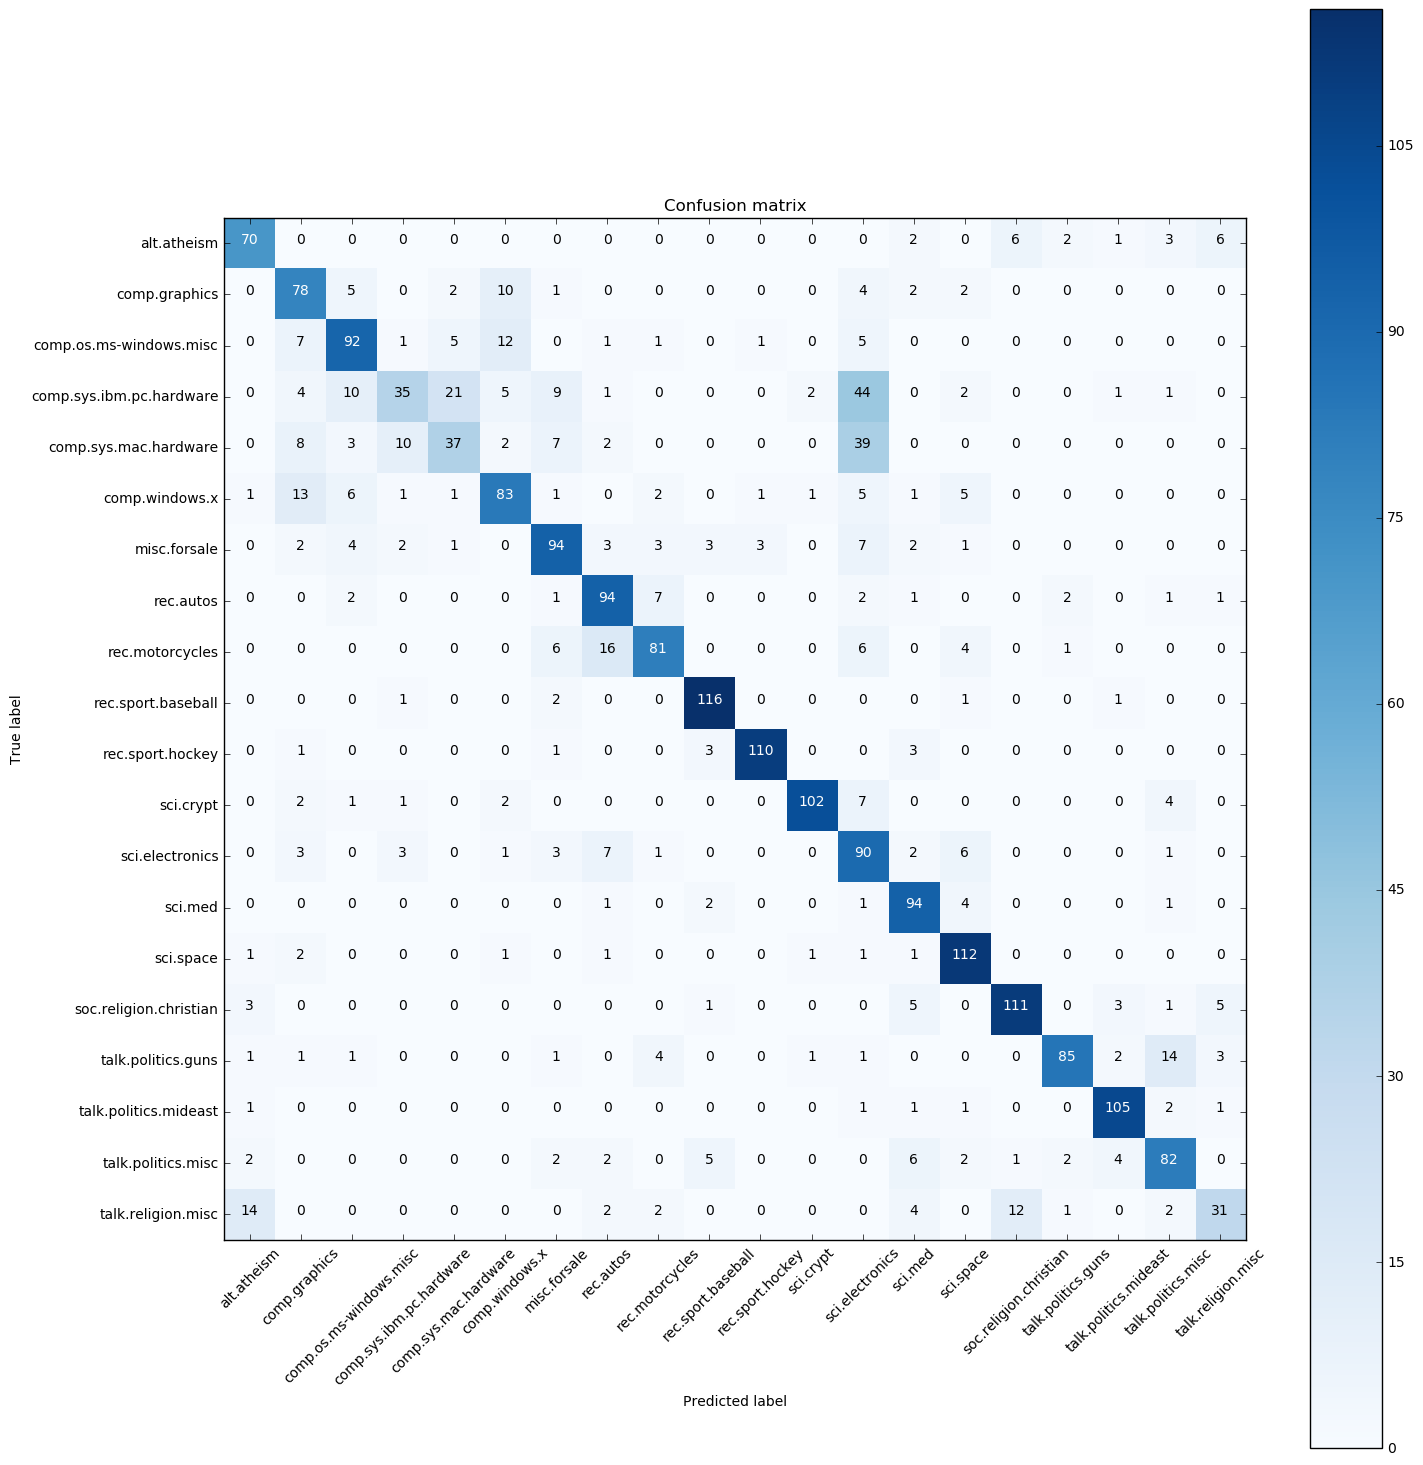

In [44]:
from sklearn import metrics
preds = model.predict(X_val)
preds = np.argmax(preds, axis=1)
y_val_actual = np.argmax(y_val, axis=1)
print "Accuracy: ", metrics.accuracy_score(y_val_actual, preds)
print "Classification report: "
print metrics.classification_report(y_val_actual, preds)
conf_mat = metrics.confusion_matrix(y_val_actual, preds)
plot_confusion_matrix(conf_mat, newsgroups_trainval.target_names)

In [45]:
# then let's save the model for future use
model.save("keras_nlp.convnet.model")

# Build features for other classifiers

http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/

So much for CNNs. We can also transform our words embeddings to features. In this case, the linked post above highlights <b>averaging word vectors for an entire document</b>. Much information is lost in this case, however, but it will be a good starting point for other techniques such as Doc2Vec.

In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict

class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(word2vec.itervalues().next())

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [79]:
# I'll be repeating the above preprocessing here.
texts = [article.encode('latin-1') for article in newsgroups_trainval.data]
labels = newsgroups_trainval.target
indices = np.arange(len(texts))
np.random.shuffle(indices)
texts = [texts[i] for i in indices]
labels = labels[indices]

nb_validation_samples = int((1-VALIDATION_SPLIT) * len(texts))

text_train = texts[:nb_validation_samples]
text_val = texts[nb_validation_samples:]
y_train = labels[:nb_validation_samples]
y_val = labels[nb_validation_samples:]

In [82]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

vectorizer = Pipeline([('vectorizer', TfidfEmbeddingVectorizer(embeddings_index)),
                       ('standardizer', StandardScaler())])
                       
X_train = vectorizer.fit_transform(text_train)
X_val = vectorizer.transform(text_val)

In [83]:
text_train = None
text_val = None
texts = None
labels = None

# Classification using SVM
## Linear SVM
The comparison is a bit unfair, but we just have to find out, don't we?

In [84]:
from sklearn.svm import LinearSVC
svc = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, C=1.0, 
                multi_class='ovr', fit_intercept=True, 
                intercept_scaling=1, class_weight='auto', verbose=2, random_state=None, max_iter=1000)

svc.fit(X_train, y_train)

/usr/local/lib/python2.7/dist-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


[LibLinear]

/usr/local/lib/python2.7/dist-packages/sklearn/svm/base.py:924: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight='auto', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=2)

Accuracy:  0.31683605833
Classification report: 
             precision    recall  f1-score   support

          0       0.33      0.42      0.37        92
          1       0.24      0.19      0.21       107
          2       0.35      0.28      0.31       140
          3       0.32      0.28      0.30       122
          4       0.34      0.10      0.15       111
          5       0.34      0.46      0.39       135
          6       0.43      0.68      0.52       120
          7       0.21      0.07      0.11       127
          8       0.28      0.24      0.26       111
          9       0.26      0.28      0.27       122
         10       0.29      0.41      0.34       118
         11       0.32      0.66      0.43       122
         12       0.19      0.07      0.10       111
         13       0.28      0.30      0.29       100
         14       0.31      0.07      0.11       119
         15       0.29      0.57      0.38       123
         16       0.30      0.23      0.26       

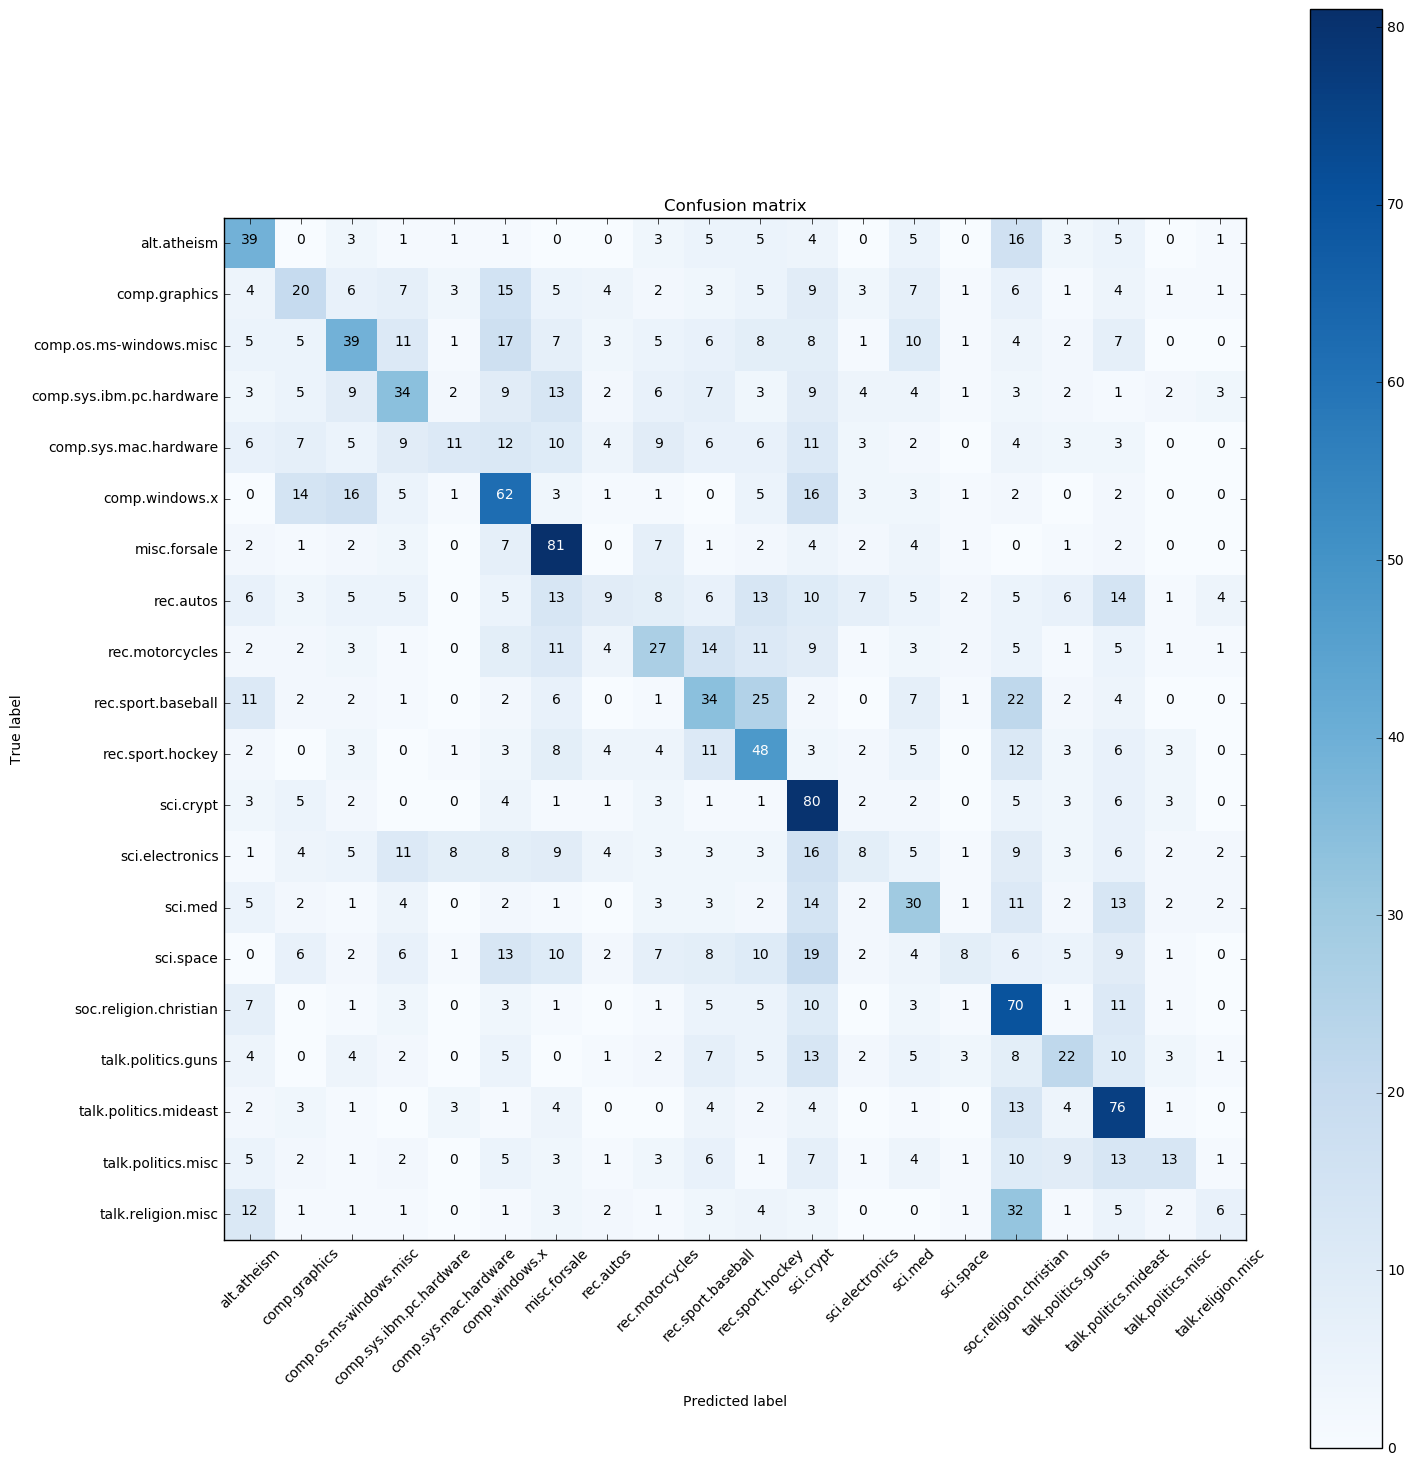

In [85]:
from sklearn import metrics
preds = svc.predict(X_val)
print "Accuracy: ", metrics.accuracy_score(y_val, preds)
print "Classification report: "
print metrics.classification_report(y_val, preds)
conf_mat = metrics.confusion_matrix(y_val, preds)

plot_confusion_matrix(conf_mat, newsgroups_trainval.target_names)

## RBF SVM
Let's add a gaussian kernel to the SVM.

In [86]:
from sklearn.svm import SVC
rbf = SVC(C=10.0, kernel='rbf', gamma='auto', class_weight='balanced', verbose=True, max_iter=-1)
rbf.fit(X_train, y_train)

[LibSVM]

SVC(C=10.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

Accuracy:  0.353954927088
Classification report: 
             precision    recall  f1-score   support

          0       0.36      0.49      0.42        92
          1       0.20      0.21      0.20       107
          2       0.40      0.27      0.32       140
          3       0.31      0.35      0.33       122
          4       0.24      0.20      0.22       111
          5       0.39      0.44      0.42       135
          6       0.56      0.57      0.57       120
          7       0.20      0.17      0.19       127
          8       0.33      0.27      0.30       111
          9       0.37      0.33      0.35       122
         10       0.42      0.42      0.42       118
         11       0.41      0.50      0.45       122
         12       0.23      0.20      0.21       111
         13       0.30      0.40      0.34       100
         14       0.24      0.20      0.22       119
         15       0.36      0.49      0.41       123
         16       0.40      0.37      0.38      

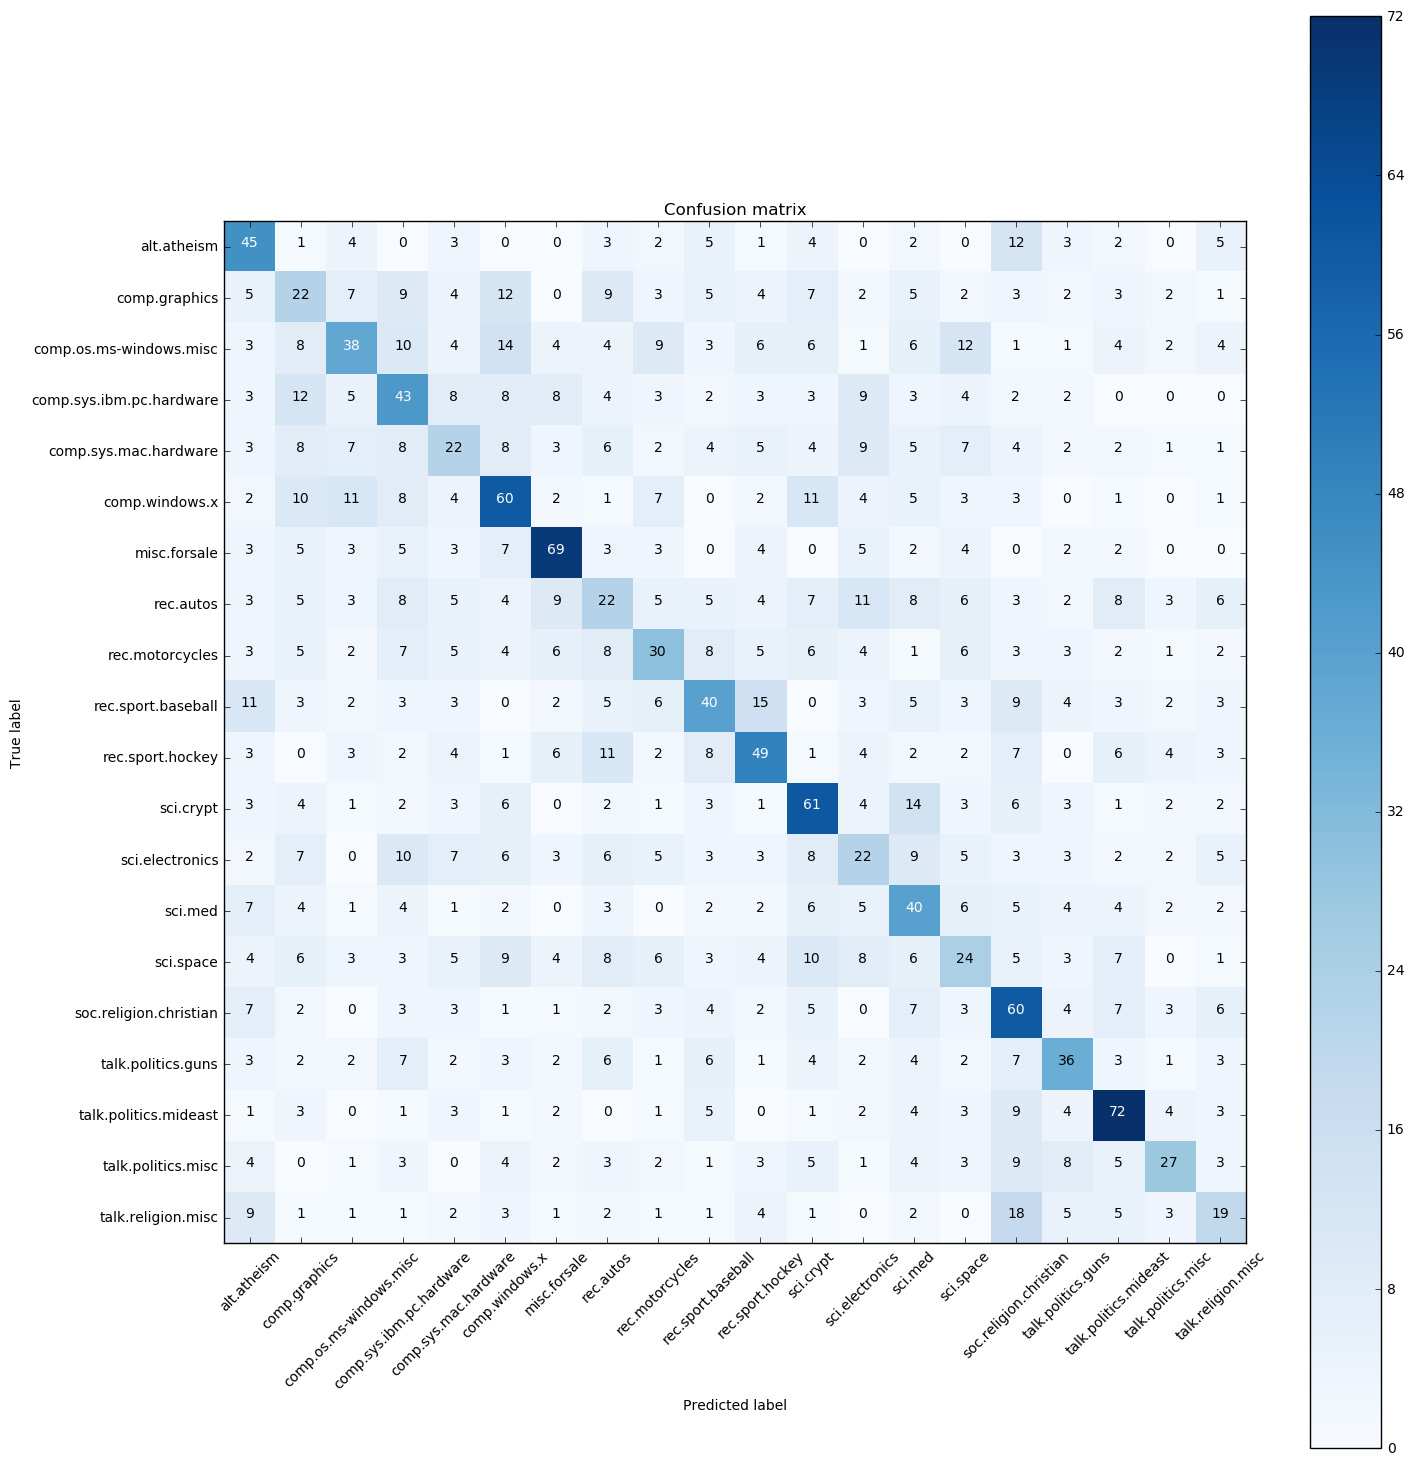

In [87]:
from sklearn import metrics
preds = rbf.predict(X_val)
print "Accuracy: ", metrics.accuracy_score(y_val, preds)
print "Classification report: "
print metrics.classification_report(y_val, preds)
conf_mat = metrics.confusion_matrix(y_val, preds)

plot_confusion_matrix(conf_mat, newsgroups_trainval.target_names)

# Classification using XGBoost
Extreme Gradient Boosting (XGBoost) is an on-the-rise meta-classifier that involves ensembles of weak classifiers trained with gradient boosting. It has won several notable Kaggle competitions. It has python support, and we'll use it here.

First off, we'll handle the unequal class distribution by supplying XGBoost with sample weights. Secondly, we'll use our validation set as our evaluation set for logging and early stopping. This is a bit frowned upon because we'll be basing our final metrics on the same validation set. <b> Please always use a separate hold-out set for logging and early stopping</b>.

In [90]:
from collections import Counter
train_weights = np.ones(len(y_train))
c = Counter(y_train)
total = len(y_train)
for cat in np.unique(y_train):
    train_weights[np.where(y_train==cat)] = float(total)/c[cat]

In [110]:
import xgboost as xgb
trees = xgb.XGBClassifier(silent=False, objective="multi:softmax", n_estimators=2000, subsample=0.5,
                          max_depth=15, min_child_weight=1, gamma=0, learning_rate=0.08)
trees.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
    eval_metric='mlogloss', sample_weight = train_weights, early_stopping_rounds=10, verbose=True,)

Will train until validation_0 error hasn't decreased in 10 rounds.
[0]	validation_0-mlogloss:2.936490
[1]	validation_0-mlogloss:2.899426
[2]	validation_0-mlogloss:2.868001
[3]	validation_0-mlogloss:2.841489
[4]	validation_0-mlogloss:2.821896
[5]	validation_0-mlogloss:2.799103
[6]	validation_0-mlogloss:2.782499
[7]	validation_0-mlogloss:2.766889
[8]	validation_0-mlogloss:2.753974
[9]	validation_0-mlogloss:2.741166
[10]	validation_0-mlogloss:2.728317
[11]	validation_0-mlogloss:2.713941
[12]	validation_0-mlogloss:2.700939
[13]	validation_0-mlogloss:2.690434
[14]	validation_0-mlogloss:2.680497
[15]	validation_0-mlogloss:2.669978
[16]	validation_0-mlogloss:2.659843
[17]	validation_0-mlogloss:2.649529
[18]	validation_0-mlogloss:2.640048
[19]	validation_0-mlogloss:2.631418
[20]	validation_0-mlogloss:2.622889
[21]	validation_0-mlogloss:2.614638
[22]	validation_0-mlogloss:2.606822
[23]	validation_0-mlogloss:2.598702
[24]	validation_0-mlogloss:2.590921
[25]	validation_0-mlogloss:2.584499
[26]	va

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.08, max_delta_step=0, max_depth=15,
       min_child_weight=1, missing=None, n_estimators=2000, nthread=-1,
       objective='multi:softmax', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=False, subsample=0.5)

Accuracy:  0.327883340698
Classification report: 
             precision    recall  f1-score   support

          0       0.31      0.41      0.35        92
          1       0.22      0.21      0.21       107
          2       0.31      0.26      0.29       140
          3       0.31      0.31      0.31       122
          4       0.26      0.23      0.24       111
          5       0.37      0.31      0.34       135
          6       0.43      0.53      0.48       120
          7       0.23      0.20      0.21       127
          8       0.29      0.27      0.28       111
          9       0.29      0.27      0.28       122
         10       0.34      0.34      0.34       118
         11       0.38      0.49      0.43       122
         12       0.23      0.23      0.23       111
         13       0.27      0.35      0.30       100
         14       0.28      0.25      0.27       119
         15       0.34      0.44      0.38       123
         16       0.34      0.33      0.34      

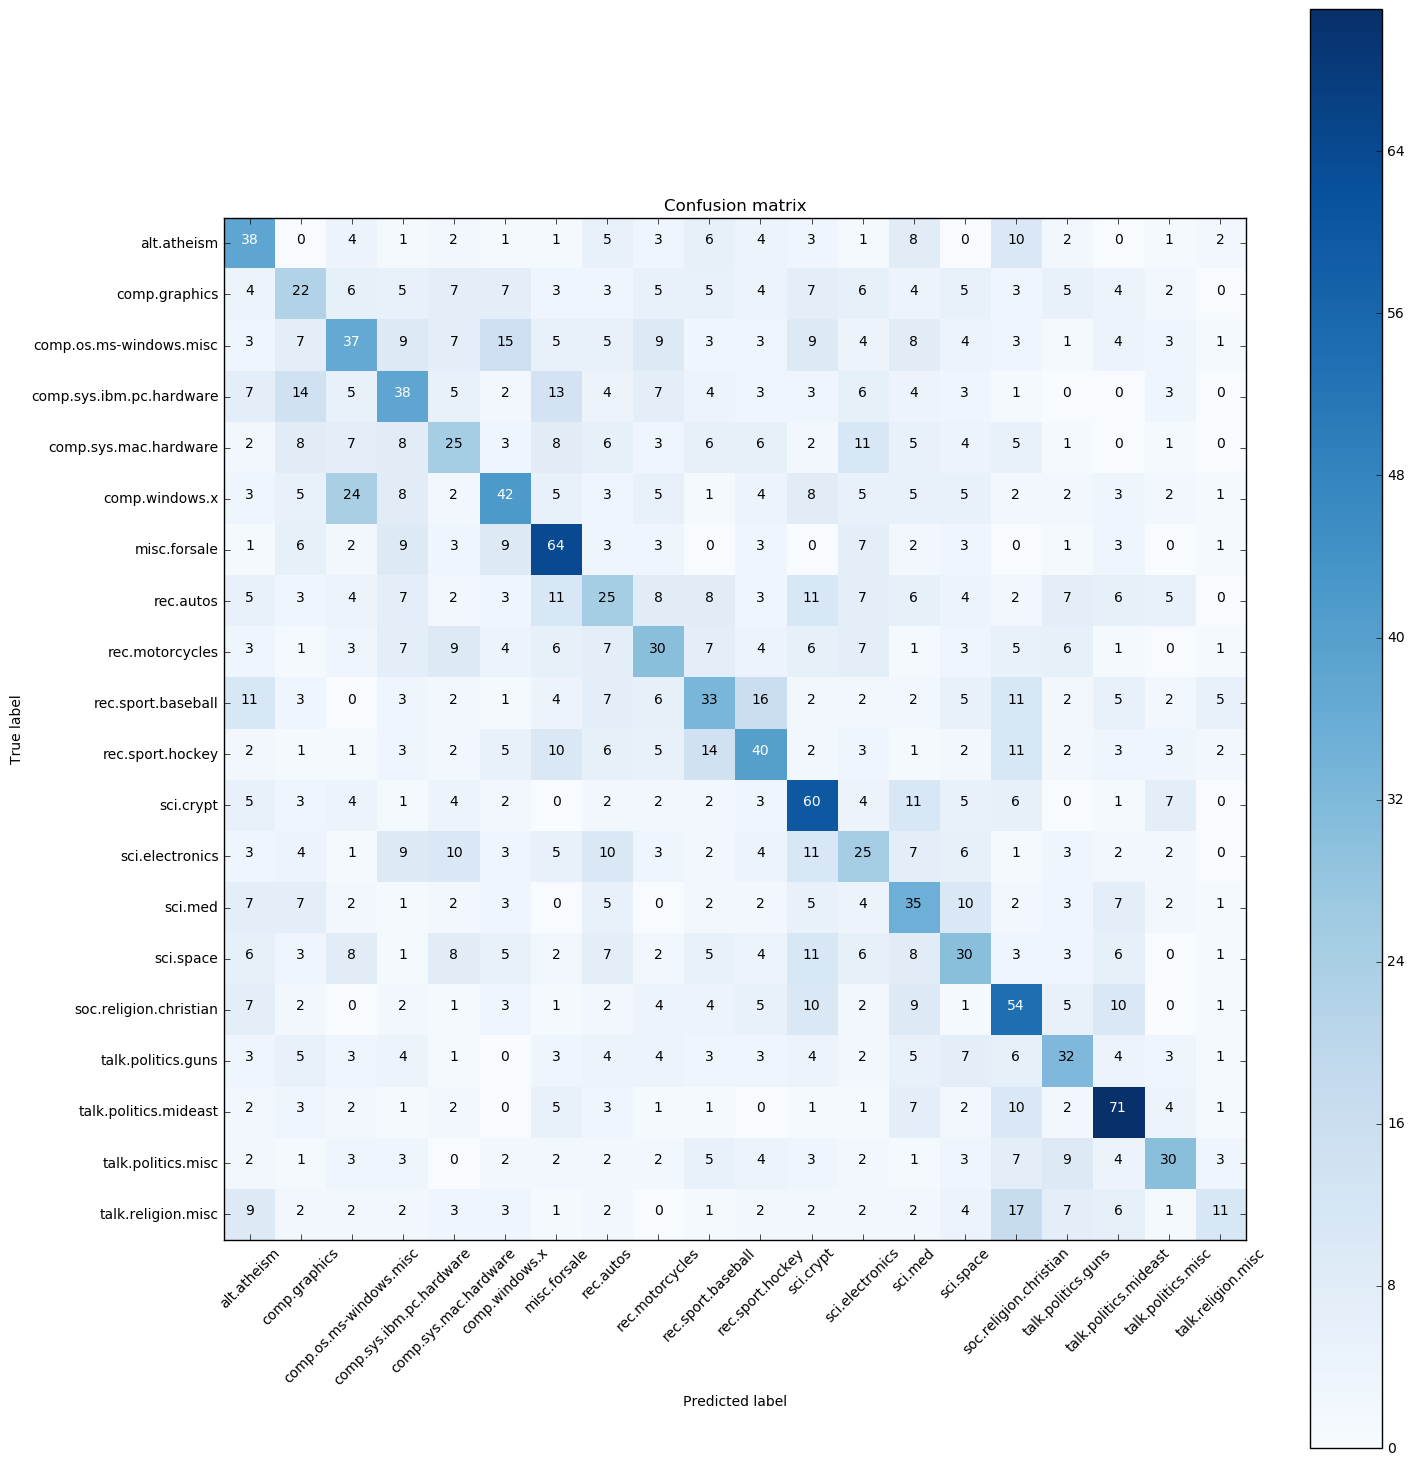

In [111]:
from sklearn import metrics
preds = trees.predict(X_val)
print "Accuracy: ", metrics.accuracy_score(y_val, preds)
print "Classification report: "
print metrics.classification_report(y_val, preds)

conf_mat = metrics.confusion_matrix(y_val, preds)
plot_confusion_matrix(conf_mat, newsgroups_trainval.target_names)

# Summary

Finally, the scores are up. Our deep learning model using word embedding did significantly better than all the rest though I'll stress that the other models were not tuned.

So in this post we have:
- used GloVe word embeddings 
- used Keras with Theano backend
- performed averaging of word embeddings for document-level classification
- used SVM and XGBoost